In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('oxfordmanrealizedvolatilityindices.csv',index_col = 0, parse_dates = True)

In [4]:
df['close_return']=df['close_price'].pct_change()
df = df.iloc[1:]

In [5]:
try:
    df_rk_return = df[['Symbol','rk_th2','close_return']]
    del df
except:
    pass

In [6]:
from sklearn.linear_model import RidgeCV
class LogHarModelWithReturn:
    
    def __init__(self, time_period=(1,5,22), forward = 1):
        self.time_period=time_period
        self.forward=forward
        
    def fit(self, data: np.ndarray, price_data):
        assert len(data) == len(price_data)
        data=np.log(data)
        assert len(data) > max(self.time_period), "the length of the data should be longer than the longest time period"
        input_data = np.array([np.convolve(data[max(self.time_period)-t:-self.forward],np.ones(t)/t,'valid') for t in self.time_period]).T
        price_input_data = np.array([np.convolve(price_data[max(self.time_period)-t:-self.forward],np.ones(t)/t,'valid') for t in self.time_period]).T
        input_data = np.concatenate([input_data,price_input_data],axis=1)
        output_data = data[max(self.time_period) + self.forward-1:]
        self.model = RidgeCV(alphas=[1e-3,1e-2,0.1,1,10])
        self.model.fit(input_data,output_data)
        
    def predict(self, data, price_data):
        assert len(data) == len(price_data)
        data = np.log(data)
        assert len(data) >= max(self.time_period)
        input_data = np.array([np.convolve(data[max(self.time_period)-t:],np.ones(t)/t,'valid') for t in self.time_period]).T
        price_input_data = np.array([np.convolve(price_data[max(self.time_period)-t:],np.ones(t)/t,'valid') for t in self.time_period]).T
        input_data = np.concatenate([input_data,price_input_data],axis=1)
        return np.exp(self.model.predict(input_data))
        

In [7]:

class forward_graph_har_return:
    def __init__(self, model = LogHarModelWithReturn(), fit_period = 200, lower_bound = 1, higher_bound = 100):
        self.model = model
        self.fit_period=fit_period
        self.lower_bound = lower_bound
        self.higher_bound = higher_bound
        
    def plot(self,data,price_data,verbose=False,log=True):
        unconditional_var=[]
        conditional_var=[]
        
        for time_forward in range(self.lower_bound, self.higher_bound+1):
            self.model.forward=time_forward
            pred_result=[]
            true_result=[]
            delta_true=[]
            count=0
            _001len = int(0.01 * len(data))
            for pos in range(self.fit_period+time_forward+max(self.model.time_period),len(data)-time_forward+1):
                if count % _001len == 0:
                    self.model.fit(data[:pos],price_data[:pos])
                count+=1
                pred_result.append(self.model.predict(data[pos-max(self.model.time_period)-1:pos],price_data[pos-max(self.model.time_period)-1:pos])[-1])
                true_result.append(data[pos+time_forward-1])
                if log:
                    delta_true.append(np.log(data[pos+time_forward-1])-np.log(data[pos-1]))
                else:
                    delta_true.append(data[pos+time_forward-1]-data[pos-1])
                    
            unconditional_var.append(np.mean(np.array(delta_true)**2))
            if verbose:
                print(true_result[:100])
                print(any(np.array(pred_result)<=0))
            if log:
                conditional_var.append(np.mean((np.log(true_result)-np.log(pred_result))**2))
            else:
                conditional_var.append(np.mean((np.array(true_result)-np.array(pred_result))**2))
            if verbose:
                print(conditional_var)
        plt.scatter(range(self.lower_bound,self.higher_bound+1),unconditional_var)
        plt.scatter(range(self.lower_bound,self.higher_bound+1),conditional_var)
        plt.legend(['unconditional_var','conditional_var'])
        plt.ylim((0,1.05*max(max(conditional_var),max(unconditional_var))))
        plt.ylabel('variance')
        plt.xlabel('lag')
#         return(conditional_var,unconditional_var)

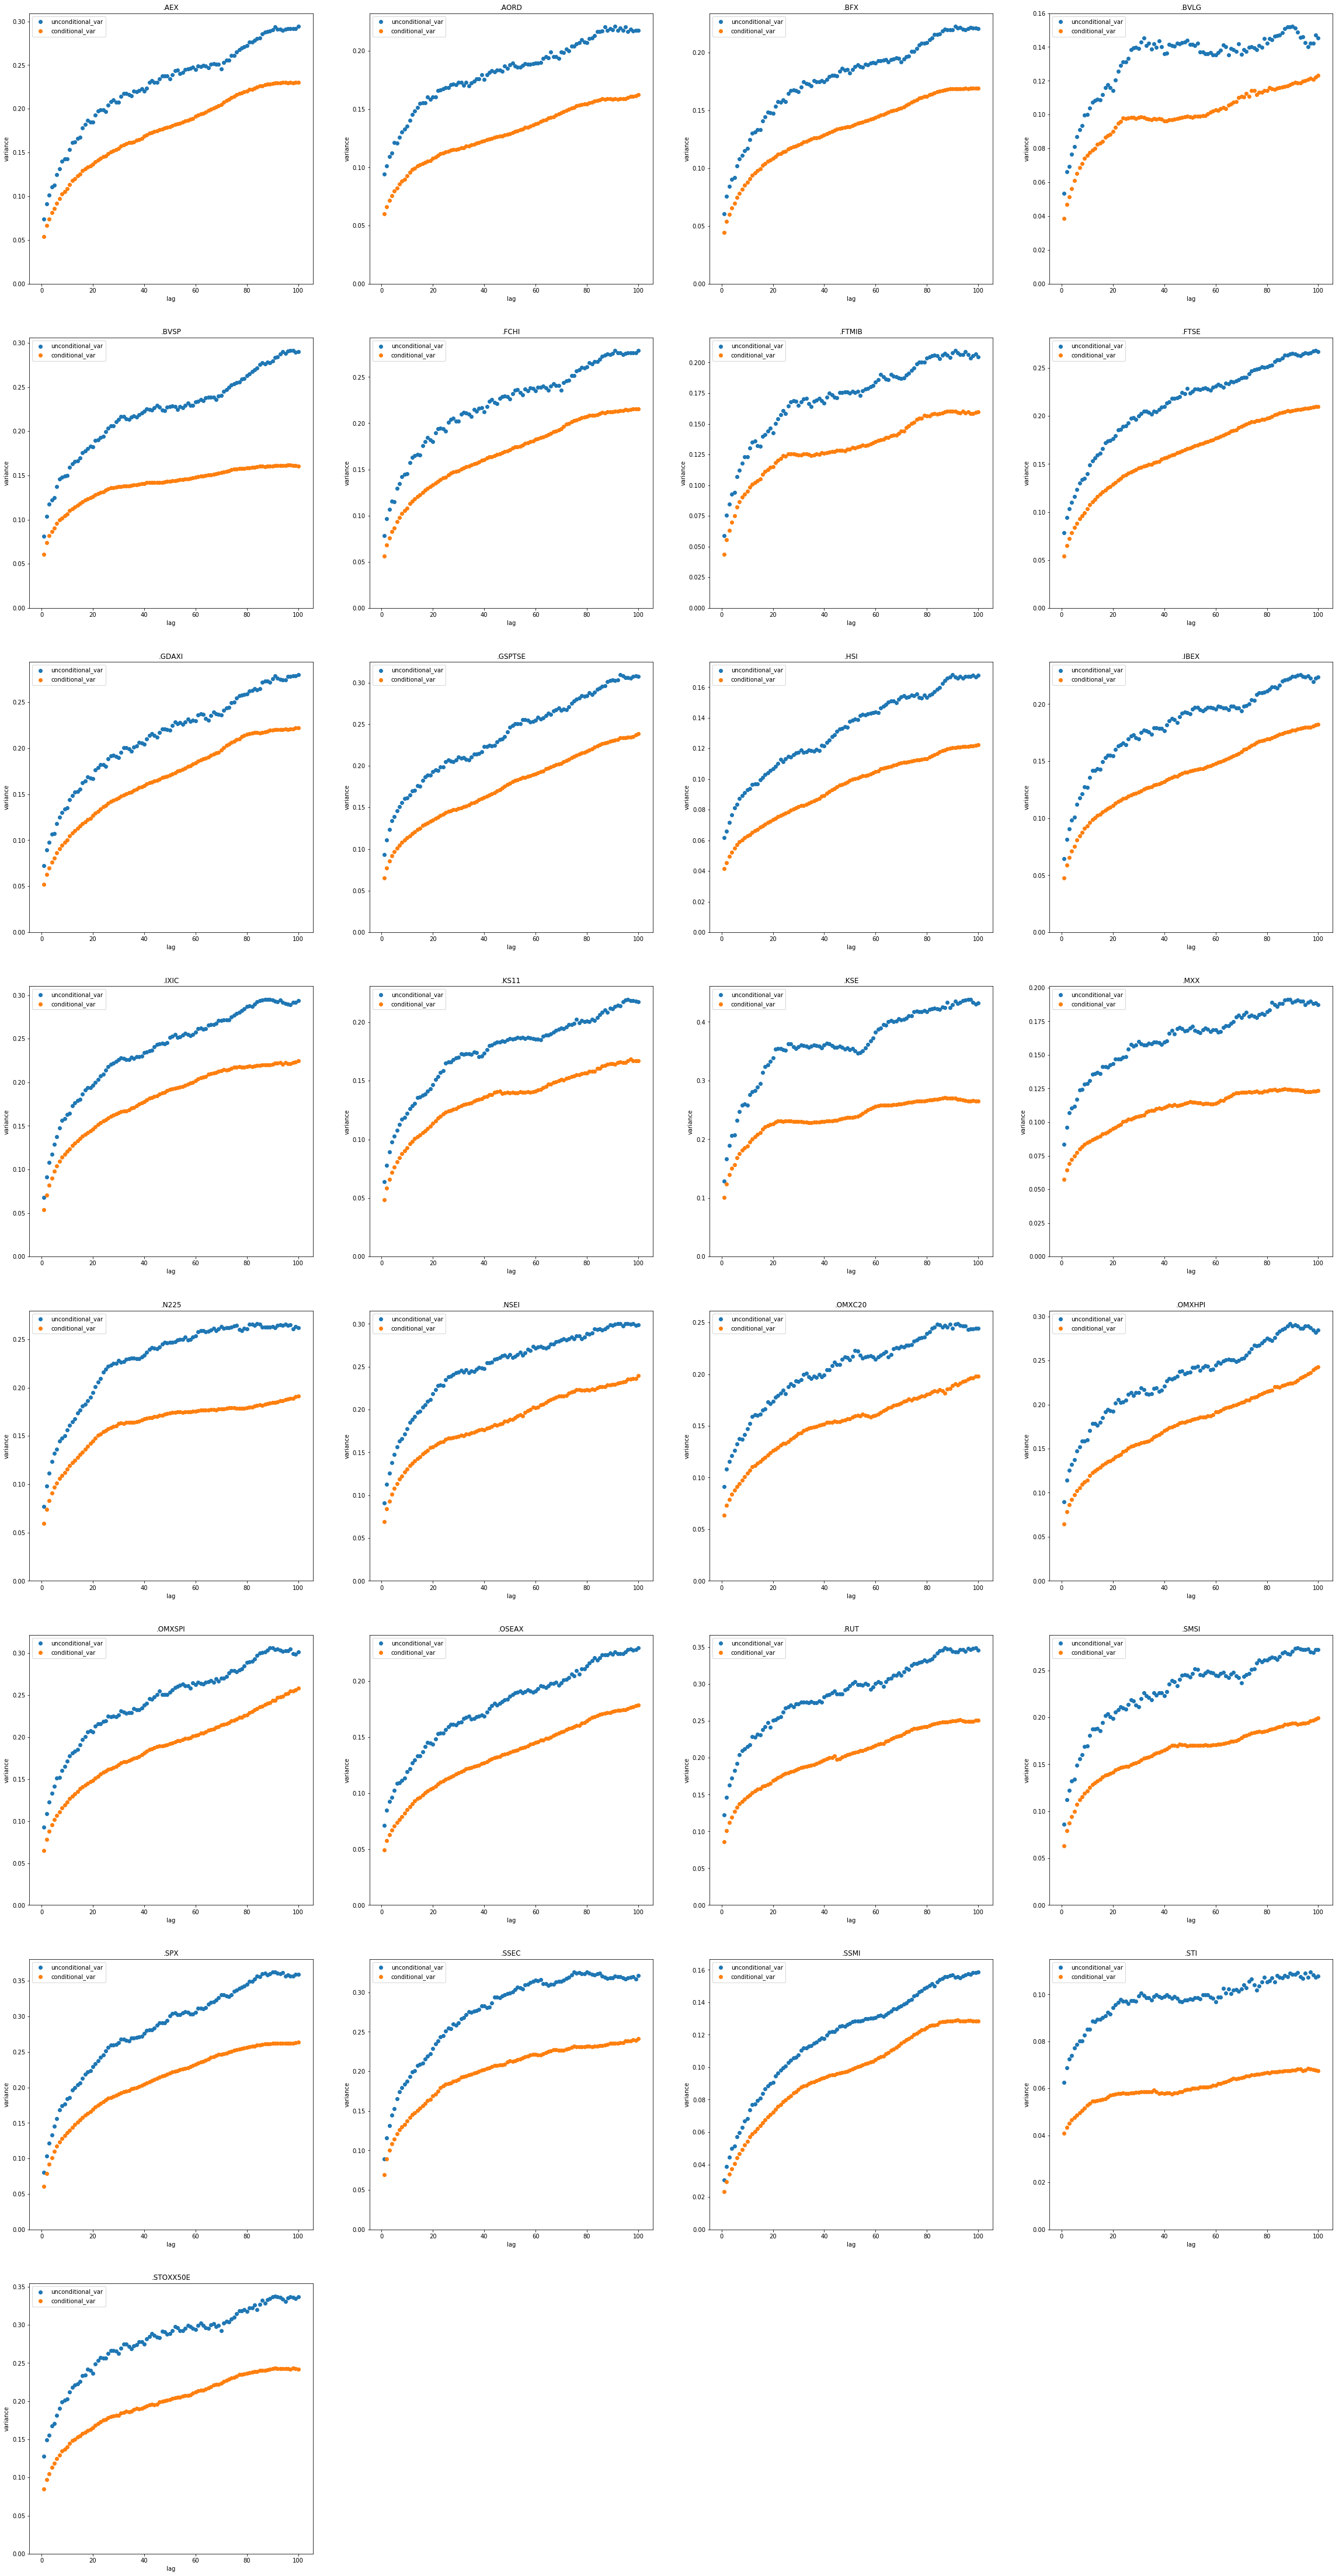

In [8]:
fgraph = forward_graph_har_return(LogHarModelWithReturn(),)
plt.figure(figsize=(40,80))
count=0
for name in tqdm(df_rk_return.Symbol.unique()):
    tempt_data=df_rk_return.query("Symbol==@name")['rk_th2'].values
    if np.min(tempt_data)<=0:
        continue
    tempt_data=np.sqrt(df_rk_return.query("Symbol==@name")['rk_th2'].values)
    
    count+=1
    plt.subplot(8,4,count)
    try:
        fgraph.plot(tempt_data,df_rk_return.query("Symbol==@name")['close_return'].values,log=True,verbose=False)
        plt.title(f"{name}")
    except:
        count-=1
    
    

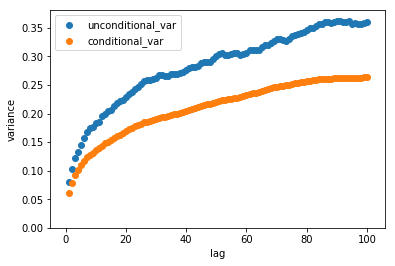

In [9]:
fgraph = forward_graph_har_return(LogHarModelWithReturn())
fgraph.plot(np.sqrt(df_rk_return.query("Symbol=='.SPX'")['rk_th2'].values),df_rk_return.query("Symbol=='.SPX'")['close_return'].values)

In [10]:
df_rk_return.query("Symbol=='.SPX'")['close_return'].values

array([ 0.60181524, -0.03797172,  0.00219439, ..., -0.01553817,
        0.00919835,  0.00647024])

In [11]:
df_rk_return.query("Symbol == '.SPX'").corr()

,rk_th2,close_return
rk_th2,1.000000,-0.061353
close_return,-0.061353,1.000000
